In [1]:
# ME EN 4650  Lab4: Flow Around a Circular Cylinder    Ryan Dalby    
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import matlab.engine # Must install from matlab installation direcotry using: cd "matlabroot\extern\engines\python" && python setup.py install 


In [2]:
# Define useful functions
mmHgToPa = lambda mmHg : mmHg*133.3 # Lambda function to covert mmHg to Pa
degCToK = lambda degC : degC+273.15 # Lambda function to covert degC to K
degToRad = lambda deg : deg * np.pi / 180 # Lambda function to covert deg to rad 
inTom = lambda inches : inches * 0.0254  # Lambda function to covert in to m 

# Define variables
root_filepath = Path('./Section14') # Data files will be assumed to be contained in ./Section14
n = 1502 # Number of time series data points in a 15 second sample
P_atm = 781 - 120.6 # Measured atmospheric pressure in lab minus the offset for Salt Lake City Utah in mmHg
air_temp = 17.5 # Measured temperature in lab in deg C 
R_dryair = 287.05 # Specific gas constant for dry air J/(kg*K)
rho_air = mmHgToPa(P_atm)/(R_dryair * degCToK(air_temp)) # Air density in lab in kg/m^3
Re = 1e4 # Reynolds number for experiment
xD_wake = 7 # The unitless distance where the downstream wake was measured
D = inTom(0.75) # Diameter of cylinder for experiment in m
H = inTom(12) # Length of cylinder for experiment in m


In [3]:
# Freestream profiles- upstream of cylinder
U_inf_mean = [] # Mean for a U_inf sample in m/s
U_inf_error = [] # 95% confidence standard error for U_inf for a sample in m/s
P_inf_mean = [] # Mean for a P_inf sample in mmHg 
P_inf_error = [] # 95% confidence standard error for a P_inf sample in mmHg
N_upstream = 5 # Number of different yD ratio values for which a 15 second sample was recorded 
YD_upstream = np.linspace(0,4,num=N_upstream)
Y_upstream = YD_upstream * D 
for i in range(N_upstream):
    # Load data
    U_inf_data = pd.read_csv((root_filepath / 'Uinf_yD{:d}.csv'.format(i)), header=None).to_numpy() # = 0.5*rho_air*U_inf**2 = P_total-P_static in mmHg 
    P_inf_data = pd.read_csv((root_filepath / 'Pinf_yD{:d}.csv'.format(i)), header=None).to_numpy() # = P_static - P_inf in mmHg

    # Calculate desired quantity
    U_inf = np.sqrt(2 * mmHgToPa(U_inf_data) / rho_air) # Convert mmHg to Pa and calculate U_inf in m/s
    P_inf = P_atm - P_inf_data # Calculate P_inf in mmHg
  
    # Calculate average of desired quantity
    U_inf_mean.append(np.average(U_inf)) 
    P_inf_mean.append(np.average(P_inf)) 

    # Calculate standard error of the mean to within 95% confidence (approx +/- 2std)
    U_inf_error.append(2*np.std(U_inf)/np.sqrt(n))
    P_inf_error.append(2*np.std(P_inf)/np.sqrt(n))
U_inf_mean = np.array(U_inf_mean)
U_inf_error = np.array(U_inf_error)
P_inf_mean = np.array(P_inf_mean)
P_inf_error = np.array(P_inf_error)
U_inf_mean_avg = np.average(U_inf_mean)
P_inf_mean_avg = np.average(P_inf_mean)

In [4]:
# Wake profiles- downstream of cylinder 
U_wake_mean = [] # Mean for a U_wake sample in m/s
U_wake_error = [] # 95% confidence standard error for a U_wake sample in m/s
U_wake_std = [] # Standard deviation for a U_wake sample in m/s
P_wake_mean = [] # Mean for a P_wake sample in mmHg
P_wake_error = [] # 95% confidence standard error for a P_wake sample in mmHg
N_downstream = 20 # Number of different yD ratio values for which a 15 second sample was recorded 
YD_downstream= np.concatenate([np.linspace(0,0.6,7),np.linspace(0.8,2.6,10),np.linspace(3,4,3)])
Y_downstream = YD_downstream * D 
for i in range(N_downstream):
    # Load data
    U_wake_data = pd.read_csv((root_filepath / ('Uwake_yD{:.1f}.csv'.format(YD_downstream[i])).replace('.','',1)), header=None).to_numpy() # = 0.5*rho_air*U_wake**2 = P_total-P_static in mmHg 
    P_wake_data = pd.read_csv((root_filepath / ('Pwake_yD{:.1f}.csv'.format(YD_downstream[i])).replace('.','',1)), header=None).to_numpy() # = P_static - P_wake in mmHg

    # Calculate desired quantity.
    U_wake = np.sqrt(2 * mmHgToPa(U_wake_data) / rho_air) # Convert mmHg to Pa and calculate U_wake in m/s
    P_wake = P_atm - P_wake_data # Calculate P_wake in mmHg
  
    # Calculate average of desired quantity
    U_wake_mean.append(np.average(U_wake)) 
    P_wake_mean.append(np.average(P_wake)) 

    # Calculate standard error of the mean to within 95% confidence
    U_wake_std.append(np.std(U_wake))
    U_wake_error.append(2*np.std(U_wake)/np.sqrt(n))
    P_wake_error.append(2*np.std(P_wake)/np.sqrt(n))
U_wake_mean = np.array(U_wake_mean)
U_wake_error = np.array(U_wake_error)
U_wake_std = np.array(U_wake_std)
P_wake_mean = np.array(P_wake_mean)
P_wake_error = np.array(P_wake_error)

In [5]:
# Cylinder pressure distribution
P_cyl_mean = [] # Mean for a P_cyl sample in mmHg
P_cyl_error = [] # 95% confidence standard error for a P_cyl sample in mmHg
P_cyl_std = []  # Standard deviation for a P_cyl sample in mmHg 
N_cyl = 24 # Number of different theta ratio values for which a 15 second sample was recorded 
theta_cyl= np.concatenate([np.linspace(0,90,19),np.linspace(100,180,5)])
for i in range(N_cyl):
    # Load data
    P_cyl_data = pd.read_csv((root_filepath / 'Pcyl_deg{:d}.csv'.format(int(theta_cyl[i]))), header=None).to_numpy() # = P_static - P_cyl in mmHg

    # Calculate desired quantity
    P_cyl = P_atm - P_cyl_data # Calculate P_cyl in mmHg
  
    # Calculate average of desired quantity
    P_cyl_mean.append(np.average(P_cyl)) 

    # Calculate standard error of the mean to within 95% confidence
    P_cyl_std.append(np.std(P_cyl))
    P_cyl_error.append(2*np.std(P_cyl)/np.sqrt(n))
P_cyl_mean = np.array(P_cyl_mean)
P_cyl_std = np.array(P_cyl_std)
P_cyl_error = np.array(P_cyl_error)


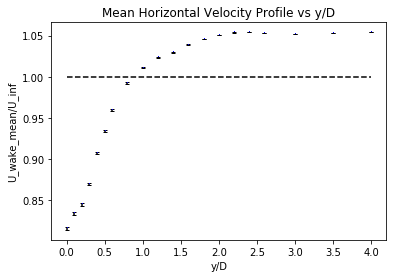

In [6]:
# Figure 1a
plt.figure()
plt.errorbar(YD_downstream, (U_wake_mean/U_inf_mean_avg), yerr=(U_wake_error/U_inf_mean_avg), marker=',', color='k', ecolor='k', markerfacecolor='b', capsize=2, linestyle='None')
plt.hlines(1.00, 0.0, 4.0, linestyles='dashed')
plt.title('Mean Horizontal Velocity Profile vs y/D')
plt.xlabel('y/D')
plt.ylabel('U_wake_mean/U_inf')
plt.show()

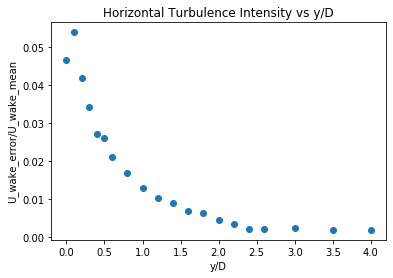

In [7]:
# Figure 1b
plt.figure()
plt.plot(YD_downstream, (U_wake_std/U_wake_mean), 'o')
plt.title('Horizontal Turbulence Intensity vs y/D')
plt.xlabel('y/D')
plt.ylabel('U_wake_error/U_wake_mean')
plt.show()

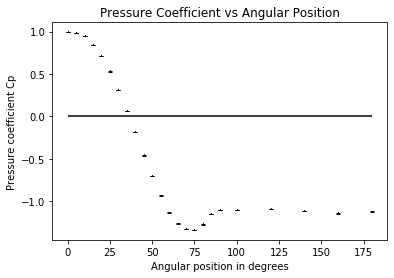

In [8]:
# Figure 1c
# Cp calculations
Cp = mmHgToPa(P_cyl_mean - P_inf_mean_avg)/(0.5*rho_air*U_inf_mean_avg**2)
Cp_error = mmHgToPa(P_cyl_error)/(0.5*rho_air*U_inf_mean_avg**2)

# Plotting
plt.title('Pressure Coefficient vs Angular Position')
plt.errorbar(theta_cyl, Cp, yerr=Cp_error, marker=',', color='k', ecolor='k', markerfacecolor='b', capsize=2, linestyle='None')
plt.hlines(0, 0, 180)
plt.xlabel('Angular position in degrees')
plt.ylabel('Pressure coefficient Cp')
plt.show()

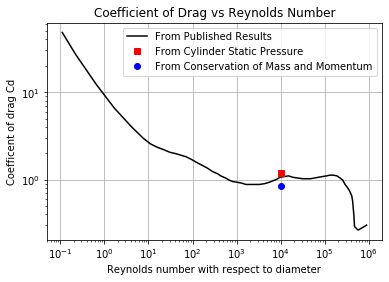

In [9]:
# Figure 1d
# Cd from published data
published_data = pd.read_csv('./CD_RE_Textbook.dat', header=None, delimiter=' ').dropna(axis=1)
Re_vals_published = published_data.iloc[:,0]
Cd_vals_published = published_data.iloc[:,1]

# Cd from cylinder static pressure
Cd_cylstatpres = np.trapz(Cp*np.cos(degToRad(theta_cyl)), x=degToRad(theta_cyl))

# Cd from conservation of mass and momentum equations
Fd = 2*np.trapz(mmHgToPa(P_inf_mean), x=Y_upstream) - 2*np.trapz(mmHgToPa(P_wake_mean), x=Y_downstream) + 2*rho_air*np.trapz(U_inf_mean**2, x=Y_upstream) - 2*rho_air*np.trapz(U_wake_mean**2, x=Y_downstream) # Drag force per length of the cylinder in N/m
Cd_consmassandmom = (Fd*H)/(0.5*rho_air*U_inf_mean_avg**2 * (H*D)) 
# Plotting
plt.title('Coefficient of Drag vs Reynolds Number')
plt.loglog(Re_vals_published, Cd_vals_published, 'k')
plt.loglog(Re, Cd_cylstatpres, 'rs')
plt.loglog(Re, Cd_consmassandmom, 'bo')
plt.grid(True)
plt.xlabel('Reynolds number with respect to diameter')
plt.ylabel('Coefficent of drag Cd')
plt.legend(['From Published Results', 'From Cylinder Static Pressure', 'From Conservation of Mass and Momentum'])
plt.show()

In [10]:
# 2a
yD_wake_end = 2.25 # Y/D value when wake ends via inspection of Figure 1a
print('The wake thickness behind the cylinder was found to be {:.2f}D, based \
on Pitot-static probe measurements taken at a downstream distance of \
x/D={:.2f} and Reynolds number of ReD={:.2f}. The wake thickness was determined as the y-location in the wake profile where the wake velocity u \
reached a plateau, i.e., became independent of y.\n\n'.format(yD_wake_end, xD_wake, Re))


The wake thickness behind the cylinder was found to be 2.25D, based on Pitot-static probe measurements taken at a downstream distance of x/D=7.00 and Reynolds number of ReD=10000.00. The wake thickness was determined as the y-location in the wake profile where the wake velocity u reached a plateau, i.e., became independent of y.




In [11]:
# 2b
U_wake_uncertainty = 2*np.abs(U_wake_std)/U_wake_mean
U_wake_max_uncertainty_idx = np.argmax(U_wake_uncertainty)
U_wake_max_uncertainty_percent = np.max(U_wake_uncertainty)*100
yD_U_wake_max_uncertainty = YD_downstream[U_wake_max_uncertainty_idx]
print('The maximum uncertainty for u_wake_mean was {:.2f}% at y/D = {:.2f}.'.format(U_wake_max_uncertainty_percent, yD_U_wake_max_uncertainty))

Pr_mean = P_cyl_mean - P_inf_mean_avg
Pr_uncertainty = 2*np.abs(np.std(P_cyl_std))/Pr_mean
Pr_max_uncertainty_idx = np.argmax(Pr_uncertainty)
Pr_max_uncertainty_percent = np.max(Pr_uncertainty)*100
theta_cyl_Pr_max_uncertainty = theta_cyl[Pr_max_uncertainty_idx]
print('The maximum uncertainty for Cp was {:.2f}% at theta = {:.2f} degrees.\n\n'.format(Pr_max_uncertainty_percent, theta_cyl_Pr_max_uncertainty))


The maximum uncertainty for u_wake_mean was 10.77% at y/D = 0.10.
The maximum uncertainty for Cp was 49.36% at theta = 35.00 degrees.




In [12]:
# 2c
print('The y/D range for which u_wake_mean/u_inf is greater than or equal to 1 is from approximately y/D = 1.0 to y/D = 4.0 (the biggest y/D value measured).\
This wake profile was measured by a Pitot-static probe where measurements were taken at a downstream distance of \
x/D={:.2f} and Reynolds number of ReD={:.2f}.\n\n'.format(xD_wake,Re))


The y/D range for which u_wake_mean/u_inf is greater than or equal to 1 is from approximately y/D = 1.0 to y/D = 4.0 (the biggest y/D value measured).This wake profile was measured by a Pitot-static probe where measurements were taken at a downstream distance of x/D=7.00 and Reynolds number of ReD=10000.00.




In [13]:
# 2d
Cd_published_interp = np.interp(Re, Re_vals_published, Cd_vals_published)
Cd_consmassandmom_errorpercent = (np.abs(Cd_published_interp-Cd_consmassandmom)/Cd_published_interp)*100
Cd_cylstatpres_errorpercent = (np.abs(Cd_published_interp-Cd_cylstatpres)/Cd_published_interp)*100

print('At a cylinder Reynolds number of ReD={:.2f}, the percent difference in \
Cd between the published results and the present data based on conservation of mass/momentum from the wake profile measurements is {:.2f}%. \
At the same Reynolds number, the percent difference in Cd between the published results and the present data based on the static pressure \
measurements around the cylinder is {:.2f}%.'.format(Re, Cd_consmassandmom_errorpercent, Cd_cylstatpres_errorpercent)) 

best_method = 'static pressure measurements around the cylinder'
if(Cd_consmassandmom_errorpercent < Cd_cylstatpres_errorpercent):
    best_method = 'conservation of mass/momentum from the wake profile'

print('From this, it is clear that the {} method yields a more accurate measure of the drag coefficient.'.format(best_method))


At a cylinder Reynolds number of ReD=10000.00, the percent difference in Cd between the published results and the present data based on conservation of mass/momentum from the wake profile measurements is 19.73%. At the same Reynolds number, the percent difference in Cd between the published results and the present data based on the static pressure measurements around the cylinder is 12.48%.
From this, it is clear that the static pressure measurements around the cylinder method yields a more accurate measure of the drag coefficient.
